# Proyecto financiero: Análisis de Bancarrota Empresarial

## Descripción

### 📌 Introducción
La predicción de bancarrota es un aspecto crucial en la gestión financiera y la toma de decisiones estratégicas dentro de las empresas. La detección temprana de riesgos financieros permite a las compañías y entidades financieras anticiparse a posibles problemas y tomar medidas preventivas. En este contexto, el uso de algoritmos de aprendizaje automático, como **XGBoost**, ofrece una solución eficiente y precisa para clasificar empresas en riesgo de quiebra.

### 🔹 Objetivo del Proyecto
El propósito principal de este análisis es desarrollar un modelo de Machine Learning capaz de predecir si una empresa se encuentra en riesgo de bancarrota utilizando un conjunto de indicadores financieros. Dado que la ocurrencia de quiebra es un evento poco frecuente, se deben aplicar técnicas para manejar el desbalance de clases y garantizar un rendimiento adecuado del modelo.

### 🔹 Metodología
Para cumplir con el objetivo, se llevaron a cabo los siguientes pasos:
1. **Carga y preprocesamiento de datos**: Se realizó la limpieza del dataset, eliminando valores nulos y detectando posibles valores atípicos.
2. **Análisis exploratorio**: Se evaluó la distribución de la variable objetivo y se identificaron patrones relevantes en los datos.
3. **Selección de variables**: Se identificaron los indicadores financieros más relevantes para la predicción de bancarrota, eliminando aquellas variables con baja importancia o redundantes..
4. **Entrenamiento del modelo XGBoost**: Se configuraron los hiperparámetros y se ajustó el modelo con los datos de entrenamiento.
5. **Evaluación del modelo**: Se analizaron métricas de rendimiento como **F1-score, Recall y AUC-ROC**.
6. **Interpretación de resultados**: Se identificaron los factores financieros más influyentes en la predicción de bancarrota.

### 🔹 Resultados
El modelo XGBoost mostró un **alto desempeño** en la clasificación de empresas con riesgo financiero, logrando:
- **F1-Score alto (0.92 para la clase de bancarrota)**, lo que indica un buen equilibrio entre precisión y recall.
- **Recall del 96%**, demostrando que el modelo detecta la mayoría de las empresas en riesgo.
- **AUC-ROC de 0.99**, lo que evidencia una gran capacidad para distinguir entre empresas estables y en quiebra.

### 🔹 Conclusión
El uso de XGBoost ha permitido desarrollar un modelo robusto y altamente preciso para la detección temprana de bancarrotas. Esto representa una herramienta valiosa para analistas financieros y tomadores de decisiones, permitiendo una evaluación efectiva del riesgo empresarial.

---


## EDA

 ### Cargue de paquetes y DataFrame

In [ ]:
import sys
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from matplotlib.ticker import PercentFormatter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
	auc,
	classification_report,
	confusion_matrix,
	roc_curve,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
# Subir un nivel desde notebooks/ para llegar a la raíz del proyecto
ROOT_DIR = Path.cwd().parents[1]
sys.path.append(str(ROOT_DIR))

In [3]:
from config import settings

In [4]:
# Configuración de visualización para mejorar la legibilidad
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

In [5]:
# Configuración de Pandas para mejor visualización
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 1000)
pd.set_option("display.float_format", "{:.2f}".format)

In [6]:
# Cargar DataFrame
print("Cargando datos...")
df = pd.read_csv(settings.RAW_DATA_DIR / "data.csv")
print(f"Datos cargados. Dimensiones: {df.shape}")

Cargando datos...
Datos cargados. Dimensiones: (6819, 96)


In [7]:
df[' Liability-Assets Flag'].value_counts()

 Liability-Assets Flag
0    6811
1       8
Name: count, dtype: int64

### Análisis inicial

In [8]:
# Vista preliminar del DataFrame
print("\n=== PRIMERAS FILAS DEL DATASET ===")
df.head(5)


=== PRIMERAS FILAS DEL DATASET ===


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.37,0.42,0.41,0.60,0.60,1.00,0.80,0.81,0.30,0.78,0.00,0.00,0.46,0.00,0.00,0.15,0.15,0.15,0.17,0.31,0.02,0.10,0.14,0.02,0.85,0.69,0.69,0.22,4980000000.00,0.00,0.26,0.36,0.00,0.00,0.63,0.02,0.21,0.79,0.01,0.39,0.01,0.10,0.14,0.40,0.09,0.00,0.00,0.00,0.00,0.03,0.03,0.39,0.04,0.67,0.17,0.19,0.00,0.00,0.00,0.15,0.33,0.28,0.00,0.68,0.72,0.34,0.03,0.90,0.00,0.06,701000000.00,6550000000.00,0.59,458000000.00,0.67,0.42,0.68,0.34,0.13,0.64,0.46,0.52,0.31,0.12,0,0.72,0.01,0.62,0.60,0.83,0.29,0.03,0.56,1,0.02
1,1,0.46,0.54,0.52,0.61,0.61,1.00,0.80,0.81,0.30,0.78,0.00,0.00,0.46,0.00,0.00,0.18,0.18,0.18,0.21,0.32,0.02,0.09,0.17,0.02,0.85,0.69,0.69,0.22,6110000000.00,0.00,0.26,0.38,0.01,0.00,0.64,0.01,0.17,0.83,0.01,0.38,0.01,0.09,0.17,0.40,0.06,0.00,0.00,9360000000.00,719000000.00,0.03,0.01,0.39,0.01,0.75,0.13,0.18,0.01,0.00,0.00,0.06,0.34,0.29,0.01,0.31,0.73,0.33,0.02,0.93,0.00,0.03,0.00,7700000000.00,0.59,2490000000.00,0.67,0.47,0.31,0.33,0.12,0.64,0.46,0.57,0.31,0.05,0,0.80,0.01,0.62,0.61,0.84,0.28,0.26,0.57,1,0.02
2,1,0.43,0.50,0.47,0.60,0.60,1.00,0.80,0.81,0.30,0.78,0.00,25500000.00,0.46,0.00,0.00,0.18,0.18,0.19,0.18,0.31,0.01,0.09,0.14,0.02,0.85,0.69,0.69,0.22,7280000000.00,0.00,0.26,0.37,0.01,0.01,0.63,0.02,0.21,0.79,0.01,0.38,0.01,0.09,0.15,0.41,0.01,0.00,0.00,65000000.00,2650000000.00,0.01,0.03,0.38,0.14,0.83,0.3

In [9]:
# Información del DataFrame
print("\n=== INFORMACIÓN DEL DATASET ===")
df.info()


=== INFORMACIÓN DEL DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null 

In [10]:
# Estadísticas descriptivas
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
df.describe().T


=== ESTADÍSTICAS DESCRIPTIVAS ===


,count,mean,std,min,25%,50%,75%,max
Bankrupt?,6819.00,0.03,0.18,0.00,0.00,0.00,0.00,1.00
ROA(C) before interest and depreciation before interest,6819.00,0.51,0.06,0.00,0.48,0.50,0.54,1.00
ROA(A) before interest and % after tax,6819.00,0.56,0.07,0.00,0.54,0.56,0.59,1.00
ROA(B) before interest and depreciation after tax,6819.00,0.55,0.06,0.00,0.53,0.55,0.58,1.00
Operating Gross Margin,6819.00,0.61,0.02,0.00,0.60,0.61,0.61,1.00
Realized Sales Gross Margin,6819.00,0.61,0.02,0.00,0.60,0.61,0.61,1.00
Operating Profit Rate,6819.00,1.00,0.01,0.00,1.00,1.00,1.00,1.00
Pre-tax net Interest Rate,6819.00,0.80,0.01,0.00,0.80,0.80,0.80,1.00
After-tax net Interest Rate,6819.00,0.81,0.01,0.00,0.81,0.81,0.81,1.00
Non-industry income and expenditure/revenue,6819.00,0.30,0.01,0.00,0.30,0.30,0.30,1.00


In [11]:
# Verificación de valores faltantes con visualización
print("\n=== ANÁLISIS DE VALORES FALTANTES ===")
missing_values = df.isnull().sum()
missing_percent = 100 * missing_values / len(df)

missing_data = pd.DataFrame(
    {"Valores Faltantes": missing_values, "Porcentaje (%)": missing_percent}
)

# Mostrar solo columnas con valores faltantes
missing_data = missing_data[missing_data["Valores Faltantes"] > 0].sort_values(
    "Porcentaje (%)", ascending=False
)

if not missing_data.empty:
    print(missing_data.to_string())

    # Visualizar valores faltantes
    plt.figure(figsize=(12, 6))
    ax = missing_data["Porcentaje (%)"].plot(kind="bar", color="crimson")
    ax.set_title("Porcentaje de Valores Faltantes por Variable", fontsize=16)
    ax.set_xlabel("Variables", fontsize=14)
    ax.set_ylabel("Porcentaje (%)", fontsize=14)
    ax.yaxis.set_major_formatter(PercentFormatter())
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No hay valores faltantes en el conjunto de datos.")


=== ANÁLISIS DE VALORES FALTANTES ===
No hay valores faltantes en el conjunto de datos.


### Visualización

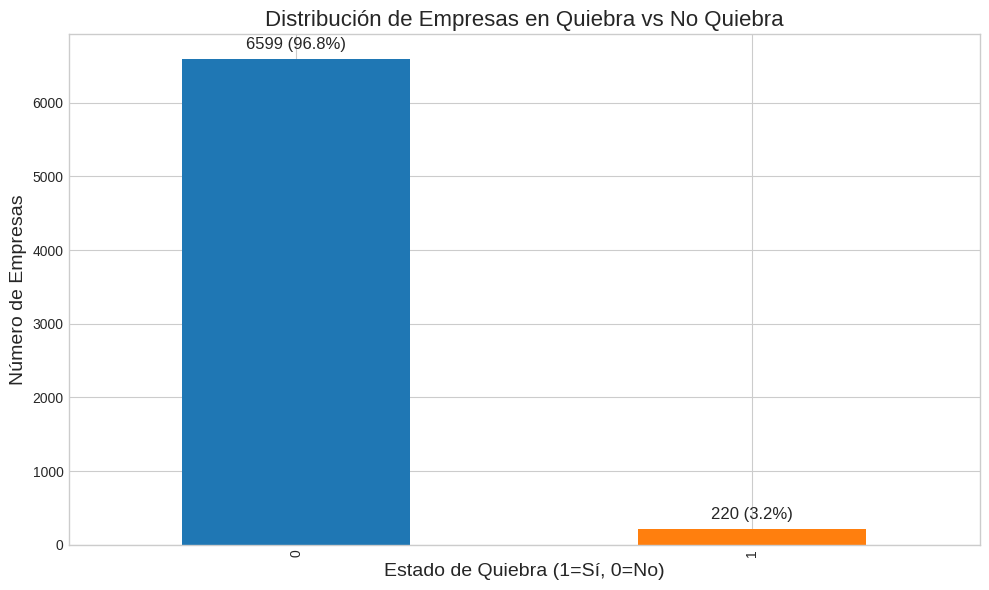

In [12]:
# Análisis de la variable objetivo
plt.figure(figsize=(10, 6))
bankrupt_counts = df["Bankrupt?"].value_counts()
ax = bankrupt_counts.plot(kind="bar", color=["#1f77b4", "#ff7f0e"])
ax.set_title("Distribución de Empresas en Quiebra vs No Quiebra", fontsize=16)
ax.set_xlabel("Estado de Quiebra (1=Sí, 0=No)", fontsize=14)
ax.set_ylabel("Número de Empresas", fontsize=14)

# Añadir etiquetas con valores y porcentajes
total = len(df)
for i, count in enumerate(bankrupt_counts):
    percentage = 100 * count / total
    ax.annotate(
        f"{count} ({percentage:.1f}%)",
        xy=(i, count),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=12,
    )

plt.tight_layout()
plt.show()

In [13]:
# Normalización y tratamiento de valores extremos
print("\n=== ANÁLISIS DE VALORES EXTREMOS ===")

# Convertir nombres de columnas a string
df.columns = df.columns.astype(str)

# Seleccionar solo las columnas numéricas
df_numeric = df.select_dtypes(include=[np.number])

# Calcular los percentiles 1% y 99%
percentiles = df_numeric.quantile([0.01, 0.99])

print("Percentiles 1% y 99% para cada variable:")
percentiles


=== ANÁLISIS DE VALORES EXTREMOS ===
Percentiles 1% y 99% para cada variable:


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0.01,0.00,0.34,0.35,0.37,0.58,0.58,1.00,0.80,0.81,0.30,0.78,0.00,0.00,0.44,0.00,0.00,0.14,0.14,0.14,0.16,0.28,0.00,0.07,0.12,0.02,0.85,0.68,0.68,0.22,0.00,0.00,0.26,0.32,0.00,0.00,0.62,0.00,0.01,0.76,0.00,0.37,0.01,0.07,0.13,0.39,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.36,0.00,0.68,0.04,0.09,0.00,0.00,0.00,0.01,0.28,0.27,0.00,0.21,0.72,0.33,0.00,0.85,0.00,0.00,0.00,0.00,0.59,0.00,0.67,0.00,0.21,0.33,0.11,0.52,0.39,0.43,0.30,0.00,0.00,0.68,0.00,0.62,0.58,0.83,0.28,0.03,0.56,1.00,0.01
0.99,1.00,0.66,0.72,0.71,0.65,0.65,1.00,0.80,0.81,0.30,0.78,9790000000.00,9440000000.00,0.52,758200000.00,0.64,0.31,0.31,0.31,0.33,0.37,0.22,0.20,0.28,0.02,0.85,0.70,0.70,0.22,9758200000.00,0.00,0.27,0.42,0.07,0.07,0.64,0.04,0.24,0.99,0.05,0.40,0.01,0.20,0.28,0.43,0.52,0.03,0.02,9730000000.00,9460000000.00,0.18,0.28,0.51,0.17,0.96,0.87,0.96,0.68,0.07,0.22,0.23,0.47,0.28,1415600000.00,1.00,0.74,0.35,1398200000.00,0.97,0.00,0.13,9788200000.00,9830000000.00,0.59,9620000000.00,0.67,0.79,1.00,0.35,0.14,0.81,0.55,0.74,0.34,0.11,0.00,0.89,0.17,0.63,0.65,0.85,0.30,0.04,0.57,1.00,0.23


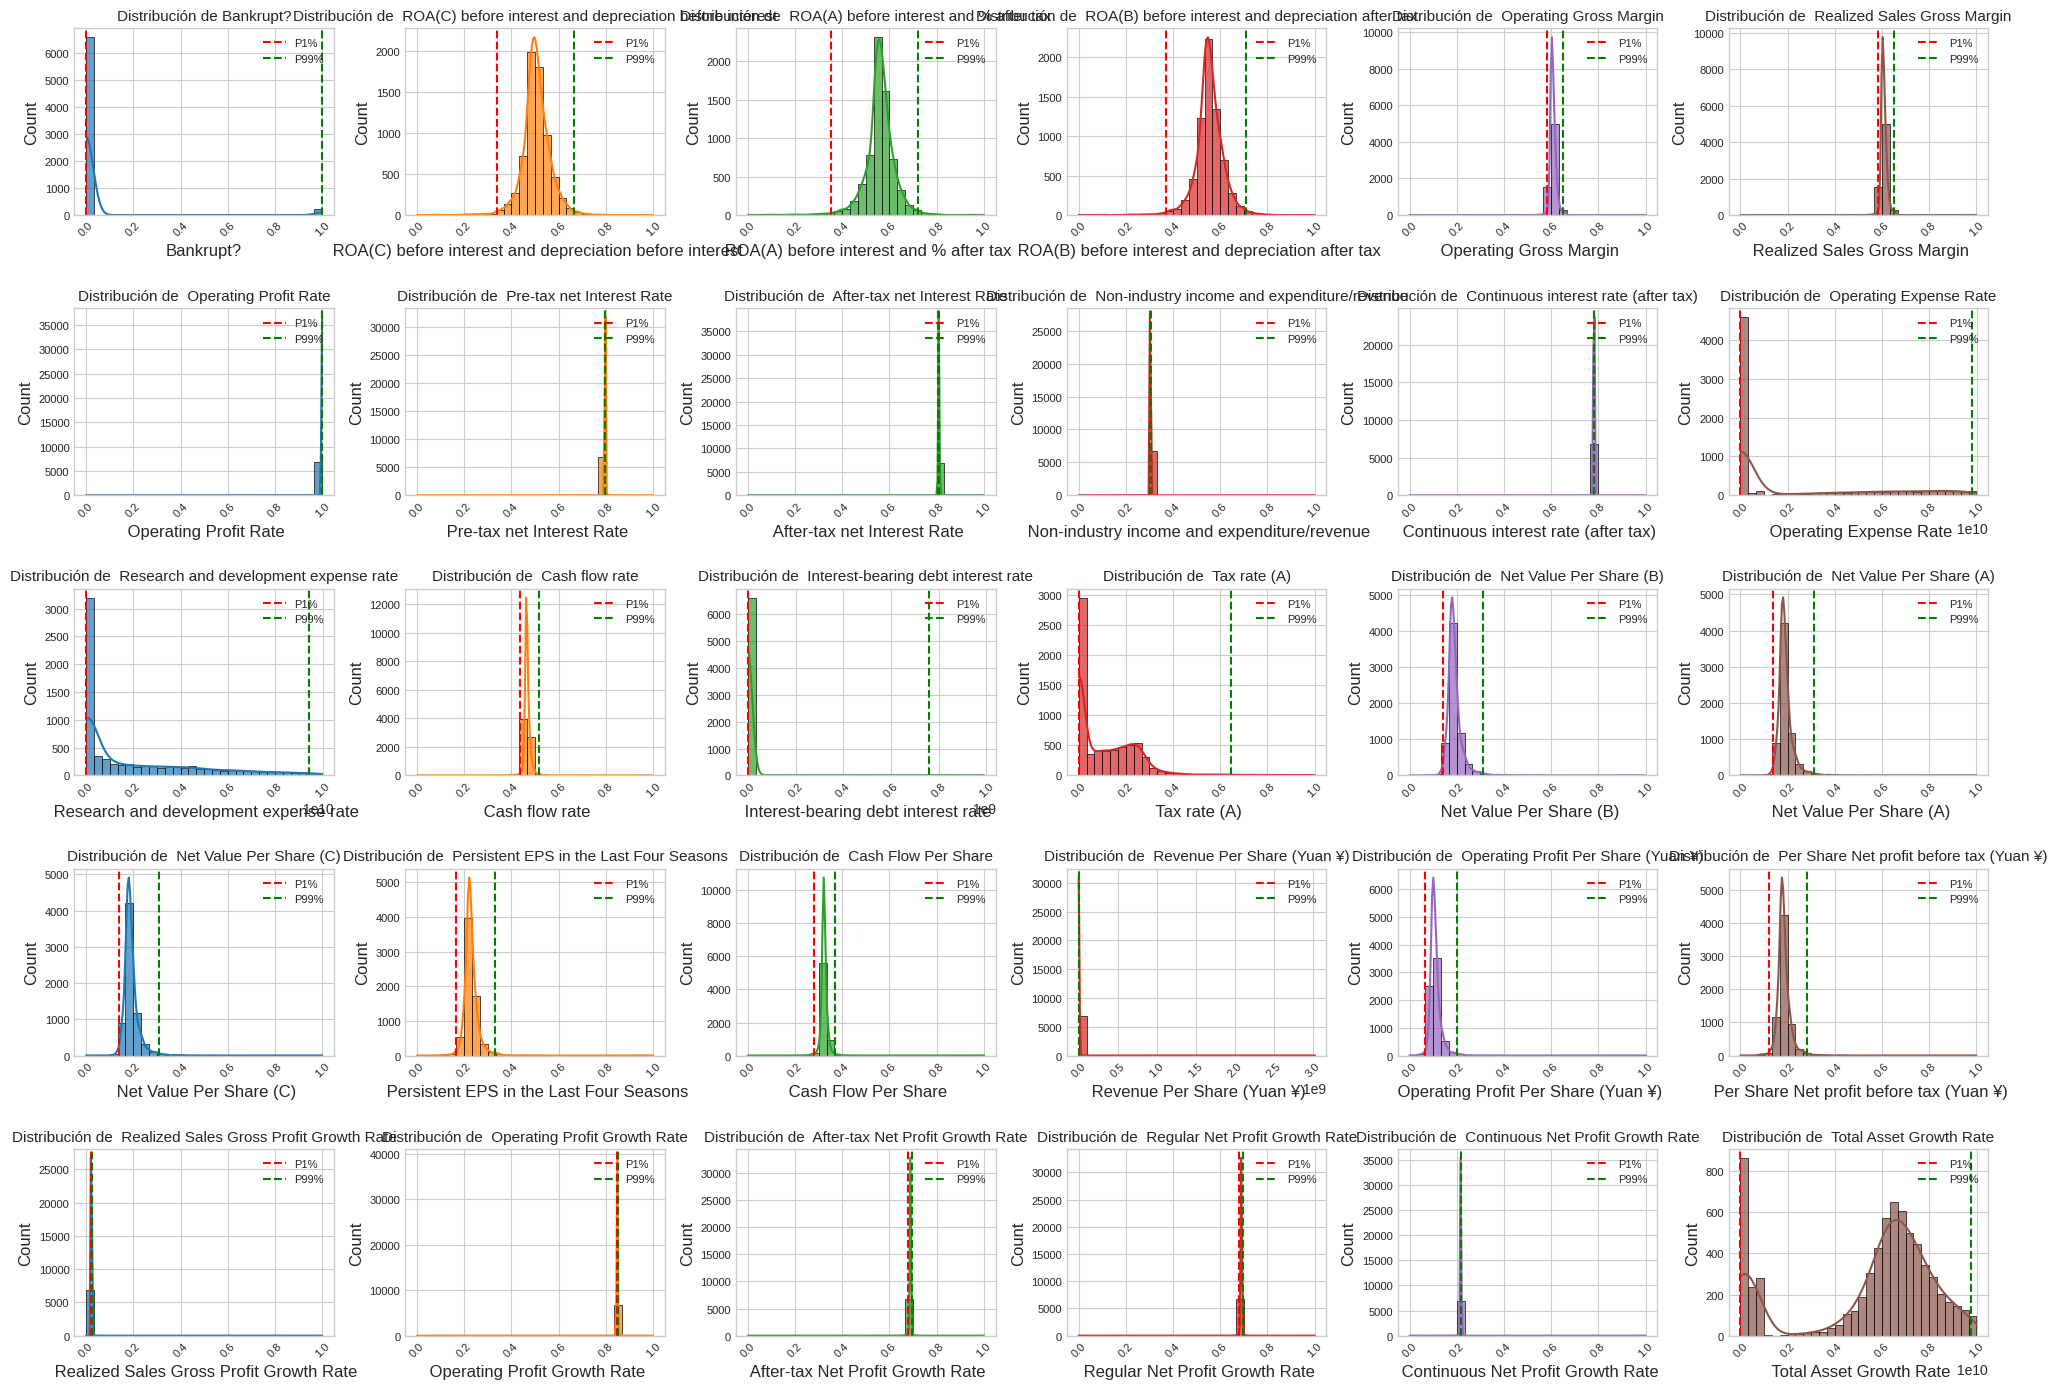

In [14]:
# Visualizar distribuciones con líneas de percentiles
# Seleccionar hasta 30 variables para mejor visualización
num_cols = len(df_numeric.columns)
cols_to_plot = min(num_cols, 30)

fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 14))
axes = axes.flatten()

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

for i, col in enumerate(df_numeric.columns[:cols_to_plot]):
    if i < len(axes):
        sns.histplot(
            df_numeric[col],
            bins=30,
            ax=axes[i],
            kde=True,
            color=colors[i % len(colors)],
            alpha=0.7,
        )
        axes[i].set_title(f"Distribución de {col}", fontsize=11)
        axes[i].axvline(
            percentiles.loc[0.01, col],
            color="r",
            linestyle="dashed",
            linewidth=1.5,
            label="P1%",
        )
        axes[i].axvline(
            percentiles.loc[0.99, col],
            color="g",
            linestyle="dashed",
            linewidth=1.5,
            label="P99%",
        )
        axes[i].legend(fontsize=8, loc="upper right")
        axes[i].tick_params(axis="x", labelrotation=45, labelsize=8)
        axes[i].tick_params(axis="y", labelsize=8)

# Ocultar ejes vacíos
for i in range(cols_to_plot, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()


=== ANÁLISIS DE VARIABLES FUERA DEL RANGO [0,1] ===


,count,mean,std,min,25%,50%,75%,max,rango
Cash Turnover Rate,6819.00,2471976967.44,2938623226.68,0.00,0.00,1080000000.00,4510000000.00,10000000000.00,10000000000.00
Current Asset Turnover Rate,6819.00,1195855763.31,2821161238.26,0.00,0.00,0.00,0.00,10000000000.00,10000000000.00
Quick Asset Turnover Rate,6819.00,2163735272.03,3374944402.17,0.00,0.00,0.00,4900000000.00,10000000000.00,10000000000.00
Operating Expense Rate,6819.00,1995347312.80,3237683890.52,0.00,0.00,0.00,4145000000.00,9990000000.00,9990000000.00
Inventory Turnover Rate (times),6819.00,2149106056.61,3247967014.05,0.00,0.00,0.00,4620000000.00,9990000000.00,9990000000.00
Total Asset Growth Rate,6819.00,5508096595.25,2897717771.17,0.00,4860000000.00,6400000000.00,7390000000.00,9990000000.00,9990000000.00
Fixed Assets Turnover Frequency,6819.00,1008595981.82,2477557316.92,0.00,0.00,0.00,0.00,9990000000.00,9990000000.00
Research and development expense rate,6819.00,1950427306.06,2598291554.00,0.00,0.00,509000000.00,3450000000.00,9980000000.00,9980000000.00
Total debt/Total net worth,6819.00,4416336.71,168406905.28,0.00,0.00,0.01,0.01,9940000000.00,9940000000.00
Inventory/Current Liability,6819.00,55806804.53,582051554.62,0.00,0.00,0.01,0.01,9910000000.00,9910000000.00


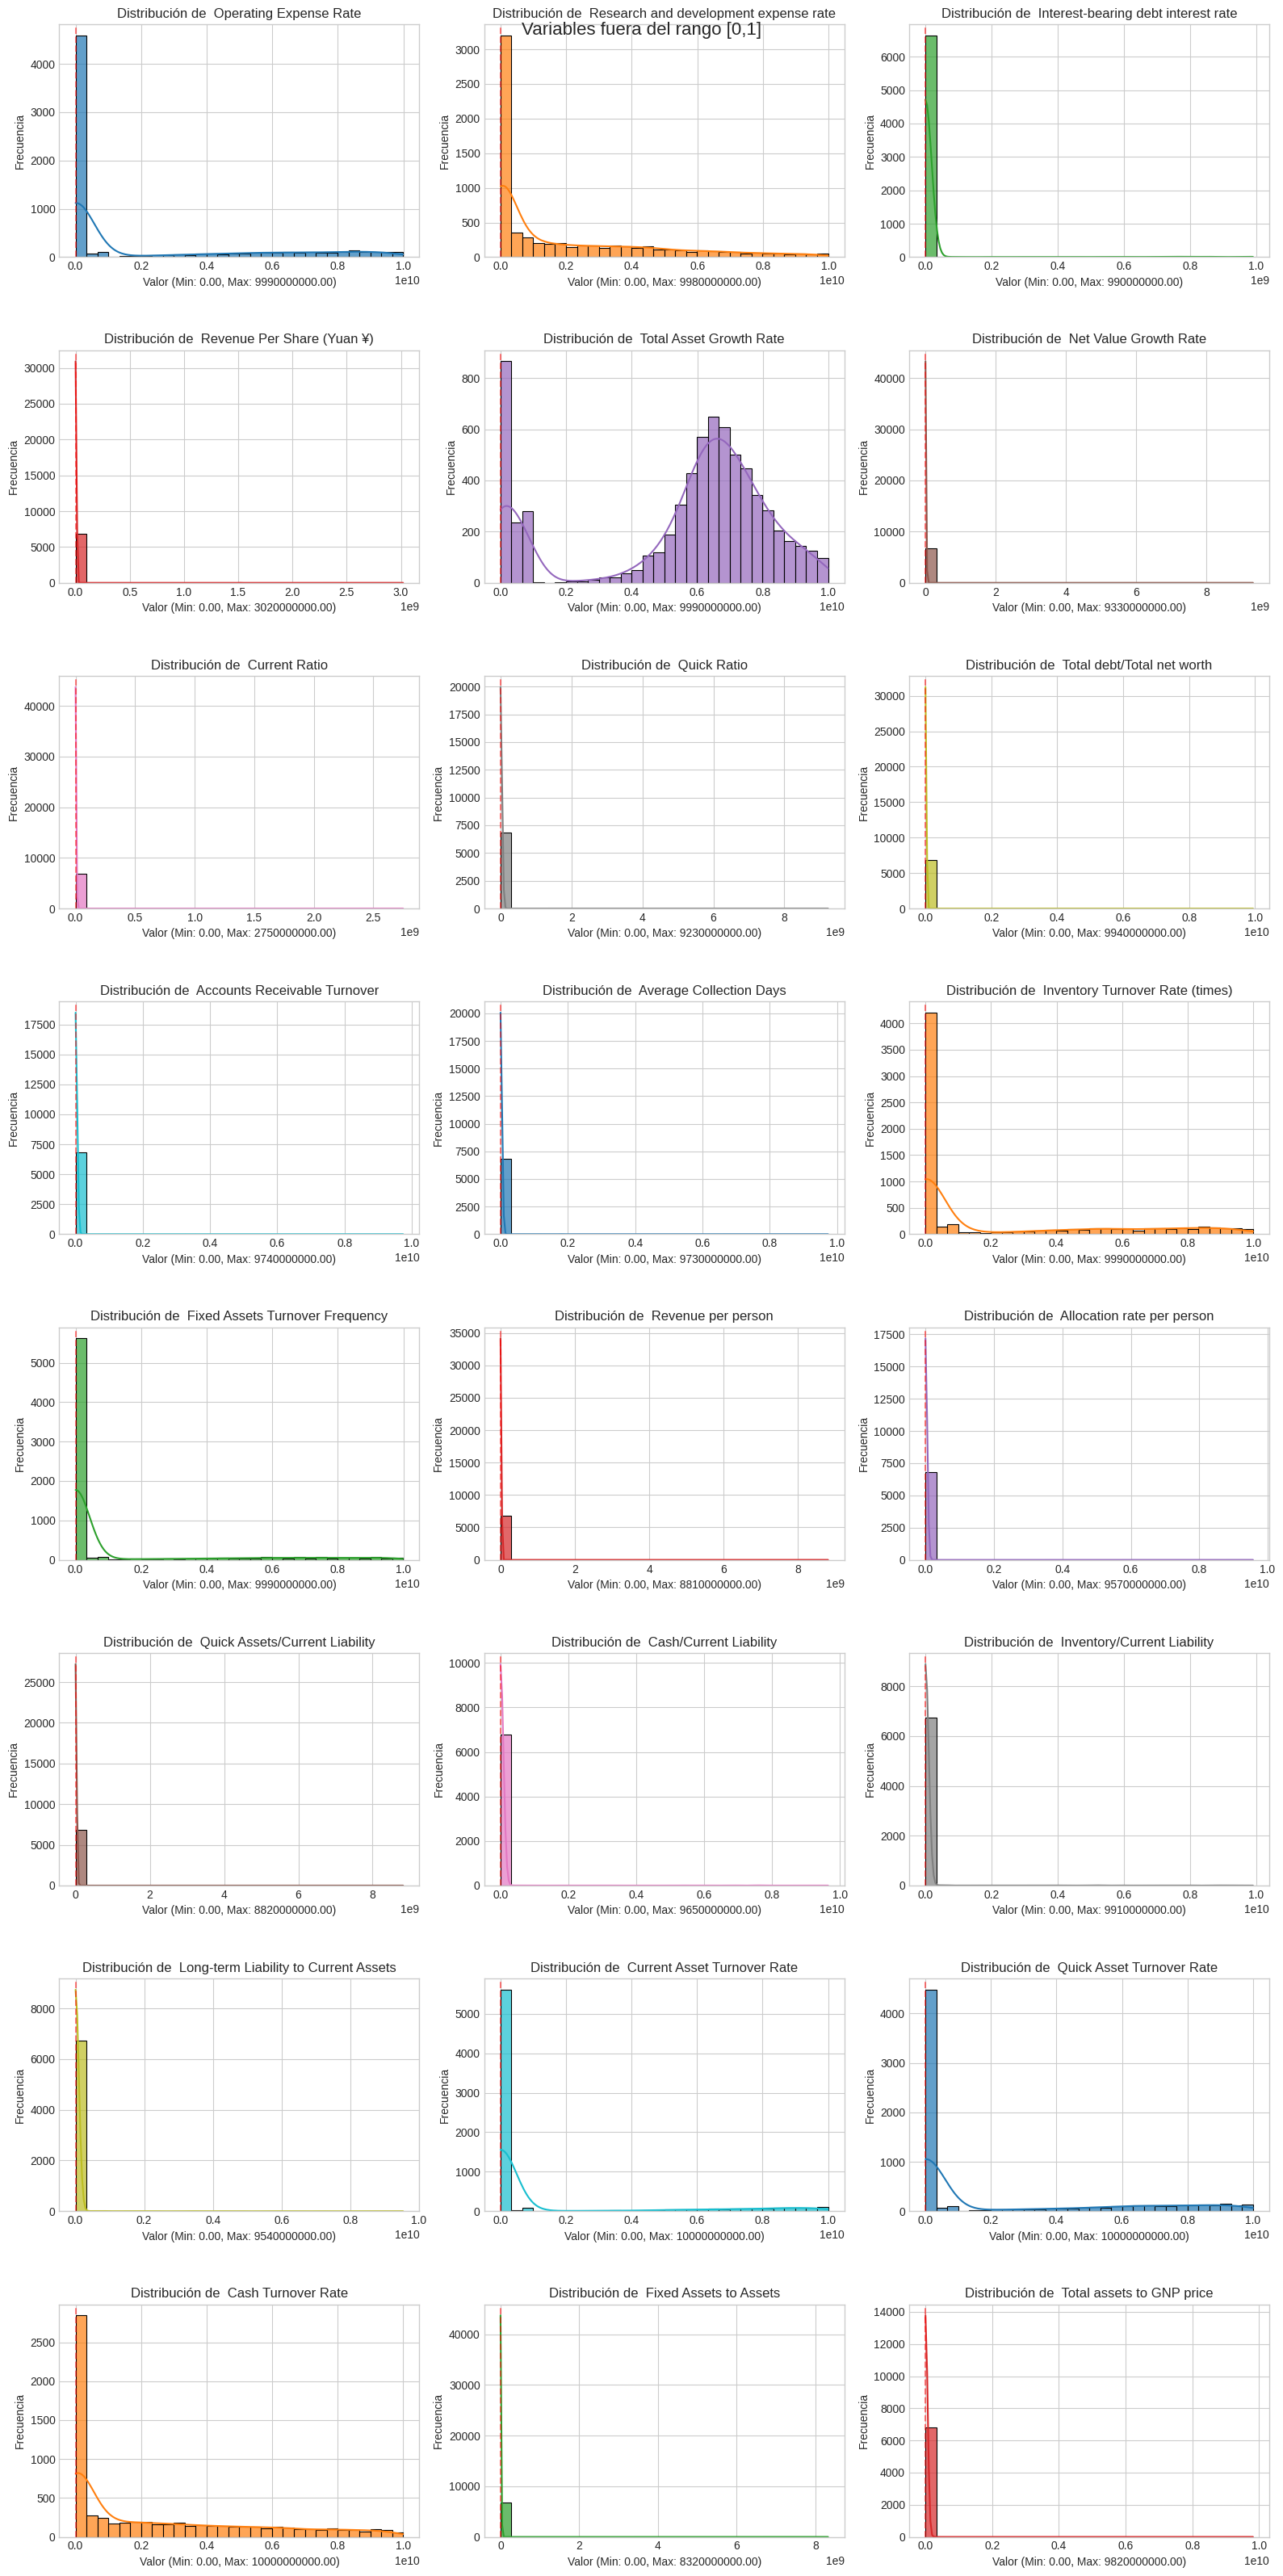

In [15]:
# Análisis de variables fuera del rango [0,1]
print("\n=== ANÁLISIS DE VARIABLES FUERA DEL RANGO [0,1] ===")

# Identificar columnas cuyos valores no están en el rango [0,1]
columnas_fuera_de_rango = (
    df.describe().T[(df.describe().T["min"] < 0) | (df.describe().T["max"] > 1)].index
)

# Extraer estadísticas de estas columnas
if len(columnas_fuera_de_rango) > 0:
    df_fuera_rango = df[columnas_fuera_de_rango].describe().T
    df_fuera_rango["rango"] = df_fuera_rango["max"] - df_fuera_rango["min"]
    display(df_fuera_rango.sort_values("rango", ascending=False))

    # Visualización de variables fuera del rango
    df_out_of_range = df.loc[:, columnas_fuera_de_rango]

    # Determinar disposición de subplots
    n_cols = min(3, len(df_out_of_range.columns))
    n_rows = (len(df_out_of_range.columns) // n_cols) + (
        1 if len(df_out_of_range.columns) % n_cols > 0 else 0
    )

    # Crear una paleta de colores
    colors = plt.cm.tab10.colors

    # Histogramas con escalas apropiadas
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, n_rows * 4))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, col in enumerate(df_out_of_range.columns):
        if i < len(axes):
            # Crear histograma sin normalización
            sns.histplot(
                df_out_of_range[col].dropna(),
                bins=30,
                kde=True,
                ax=axes[i],
                color=colors[i % len(colors)],
                alpha=0.7,
            )

            # Establecer límites explícitos para los ejes
            min_val = df_out_of_range[col].min()
            max_val = df_out_of_range[col].max()
            margin = (max_val - min_val) * 0.05  # 5% de margen
            axes[i].set_xlim(min_val - margin, max_val + margin)

            # Añadir título y etiquetas informativas
            axes[i].set_title(f"Distribución de {col}", fontsize=12)
            axes[i].set_xlabel(
                f"Valor (Min: {min_val:.2f}, Max: {max_val:.2f})", fontsize=10
            )
            axes[i].set_ylabel("Frecuencia", fontsize=10)

            # Añadir una línea vertical en 0 y 1 para referencia si están en el rango
            if min_val < 0 < max_val:
                axes[i].axvline(0, color="red", linestyle="--", alpha=0.5)
            if min_val < 1 < max_val:
                axes[i].axvline(1, color="red", linestyle="--", alpha=0.5)

    # Ocultar ejes vacíos
    for i in range(len(df_out_of_range.columns), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle("Variables fuera del rango [0,1]", fontsize=16, y=0.99)
    plt.show()
else:
    print("No se encontraron variables fuera del rango [0,1]")

### Análisis de Valores Atípicos en Datos Financieros

Para el contexto de este ejercicio, los datos "atípicos" deben ser considerados, dado que en las empresas, especialmente aquellas que cotizan en bolsa, es común encontrar algunas con cifras de ingresos o gastos mucho más elevadas que otras.

#### Observaciones a partir de las Gráficas

1. **Sesgo extremo a la derecha:**  
   - Variables como *Operating Expense Rate, Interest-bearing debt interest rate y Revenue Per Share* presentan valores máximos desproporcionadamente grandes.
   - Esto sugiere la presencia de empresas con tamaños o estrategias financieras muy diferentes.

2. **Acumulación de valores en torno a cero:**  
   - Muchas métricas, como *Accounts Receivable Turnover* y *Quick Ratio*, muestran una gran concentración de valores cercanos a cero.
   - Indica que muchas empresas pueden no utilizar estos elementos de manera significativa en su operativa.

3. **Escalas de valores excesivas:**  
   - Algunas variables alcanzan cifras extremadamente altas (del orden de **10^9 o más**).
   - Esto podría deberse a:
     - Diferencias en monedas o unidades de medida.
     - Existencia de empresas de gran tamaño dentro del conjunto de datos.

4. **Distribución de percentiles 1% y 99%:**
   - En las gráficas, se observan líneas verticales que indican estos percentiles.
   - Variables como *ROA(A), ROA(B) y ROA(C)* muestran concentraciones alrededor de valores medios, pero con colas largas.
   - Métricas como *Operating Expense Rate y Research & Development Expense Rate* tienen percentiles superiores extremadamente elevados, lo que confirma la presencia de valores extremos significativos.


=== MATRIZ DE CORRELACIÓN ===


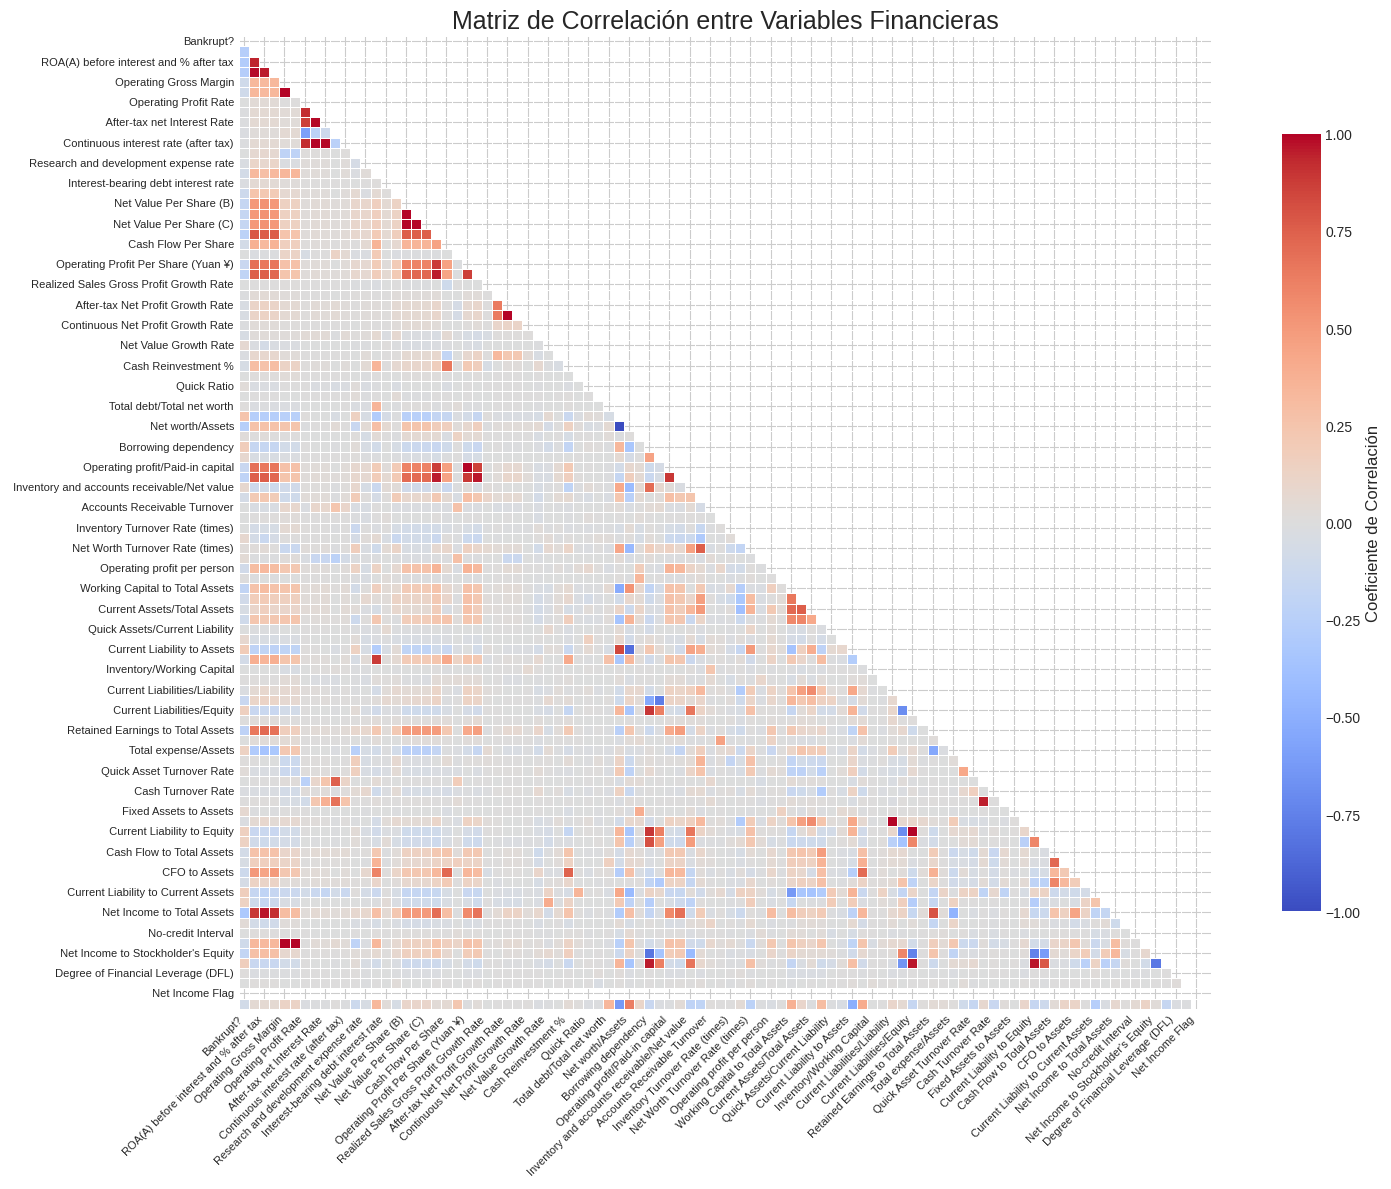

In [16]:
# Matriz de correlación
print("\n=== MATRIZ DE CORRELACIÓN ===")

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear un mapa de calor más legible
plt.figure(figsize=(16, 12))

# Generar máscara para la mitad superior (para evitar redundancia)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Crear heatmap con colorbar personalizado
heatmap = sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    annot=False,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Coeficiente de Correlación"},
)

plt.title("Matriz de Correlación entre Variables Financieras", fontsize=18)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

## Selección variables para aplicación de modelos


=== CORRELACIONES FUERTES (|r| > 0.8) ===


,Variable 1,Variable 2,Correlación,Correlación_Abs
0,Current Liabilities/Liability,Current Liability to Liability,1.00,1.00
1,Debt ratio %,Net worth/Assets,-1.00,1.00
2,Operating Gross Margin,Gross Profit to Sales,1.00,1.00
3,Net Value Per Share (A),Net Value Per Share (C),1.00,1.00
4,Operating Gross Margin,Realized Sales Gross Margin,1.00,1.00
5,Realized Sales Gross Margin,Gross Profit to Sales,1.00,1.00
6,Net Value Per Share (B),Net Value Per Share (A),1.00,1.00
7,Net Value Per Share (B),Net Value Per Share (C),1.00,1.00
8,Operating Profit Per Share (Yuan ¥),Operating profit/Paid-in capital,1.00,1.00
9,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,1.00,1.00


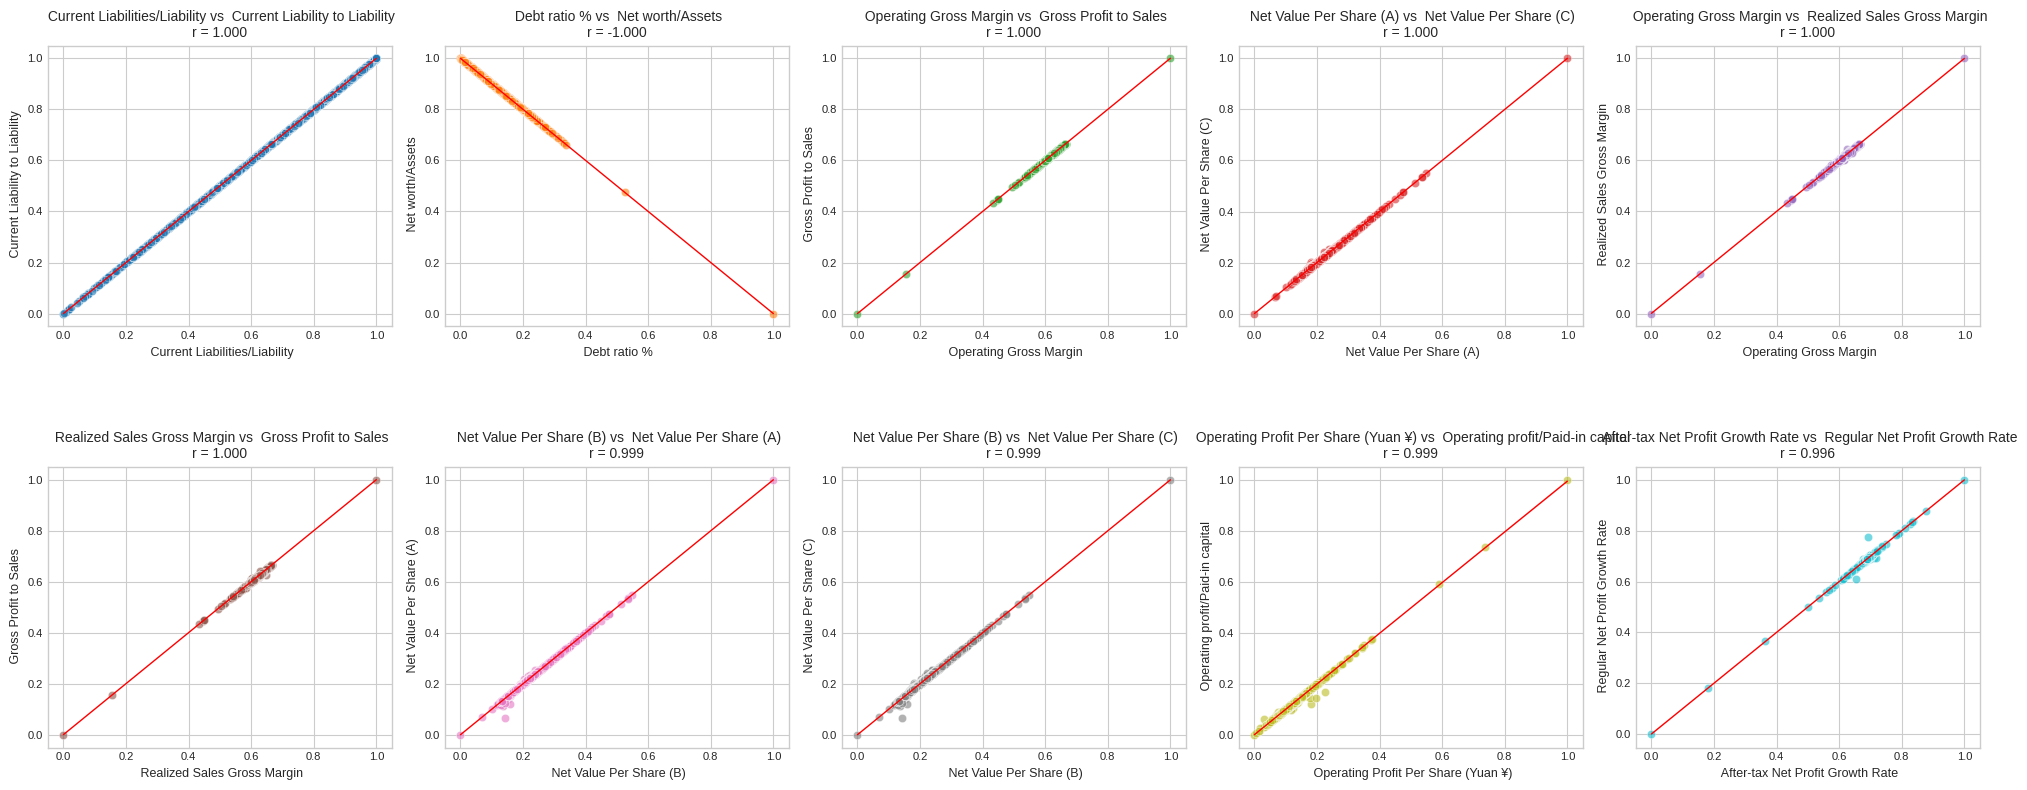

In [17]:
# Identificación de correlaciones fuertes con formato mejorado
print("\n=== CORRELACIONES FUERTES (|r| > 0.8) ===")

# Filtrar las correlaciones fuertes (mayor a 0.8 o menor a -0.8)
strong_correlations = corr_matrix[(corr_matrix > 0.8) | (corr_matrix < -0.8)]

# Convertir la matriz en formato de pares de variables
corr_pairs = strong_correlations.unstack().reset_index()
corr_pairs.columns = ["Variable 1", "Variable 2", "Correlación"]

# Eliminar valores duplicados y correlaciones consigo mismas
corr_pairs = corr_pairs[corr_pairs["Variable 1"] != corr_pairs["Variable 2"]]
corr_pairs = corr_pairs.drop_duplicates(subset=["Correlación"])

# Ordenar por el valor absoluto de la correlación
corr_pairs["Correlación_Abs"] = np.abs(corr_pairs["Correlación"])
corr_pairs = corr_pairs.sort_values(by="Correlación_Abs", ascending=False)
corr_pairs = corr_pairs[["Variable 1", "Variable 2", "Correlación", "Correlación_Abs"]]

# Mostrar las correlaciones más fuertes
if not corr_pairs.empty:
    # Mostrar solo las primeras 20 para evitar sobrecarga
    display(corr_pairs.reset_index(drop=True).head(20).round(4))

    # Visualización de pares con correlaciones más fuertes
    top_pairs = corr_pairs.head(10)  # Top 10 correlaciones

    # Crear subplots para visualizar los pares más correlacionados
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
    axes = axes.flatten()

    for i, (_, row) in enumerate(top_pairs.iterrows()):
        if i < len(axes):
            var1 = row["Variable 1"]
            var2 = row["Variable 2"]
            corr_val = row["Correlación"]

            # Crear scatter plot
            sns.scatterplot(
                x=var1,
                y=var2,
                data=df,
                ax=axes[i],
                alpha=0.6,
                color=colors[i % len(colors)],
            )

            # Añadir línea de regresión
            sns.regplot(
                x=var1,
                y=var2,
                data=df,
                ax=axes[i],
                scatter=False,
                line_kws={"color": "red", "lw": 1},
            )

            axes[i].set_title(f"{var1} vs {var2}\nr = {corr_val:.3f}", fontsize=10)
            axes[i].tick_params(axis="both", labelsize=8)
            axes[i].set_xlabel(var1, fontsize=9)
            axes[i].set_ylabel(var2, fontsize=9)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()
else:
    print("No se encontraron correlaciones fuertes (|r| > 0.8).")


=== CORRELACIÓN CON LA VARIABLE OBJETIVO 'Bankrupt?' ===


,Variable,Correlación_Abs,Correlación
0,Bankrupt?,1.00,1.00
1,Net Income to Total Assets,0.32,-0.32
2,ROA(A) before interest and % after tax,0.28,-0.28
3,ROA(B) before interest and depreciation after...,0.27,-0.27
4,ROA(C) before interest and depreciation befor...,0.26,-0.26
5,Net worth/Assets,0.25,-0.25
6,Debt ratio %,0.25,0.25
7,Persistent EPS in the Last Four Seasons,0.22,-0.22
8,Retained Earnings to Total Assets,0.22,-0.22
9,Net profit before tax/Paid-in capital,0.21,-0.21


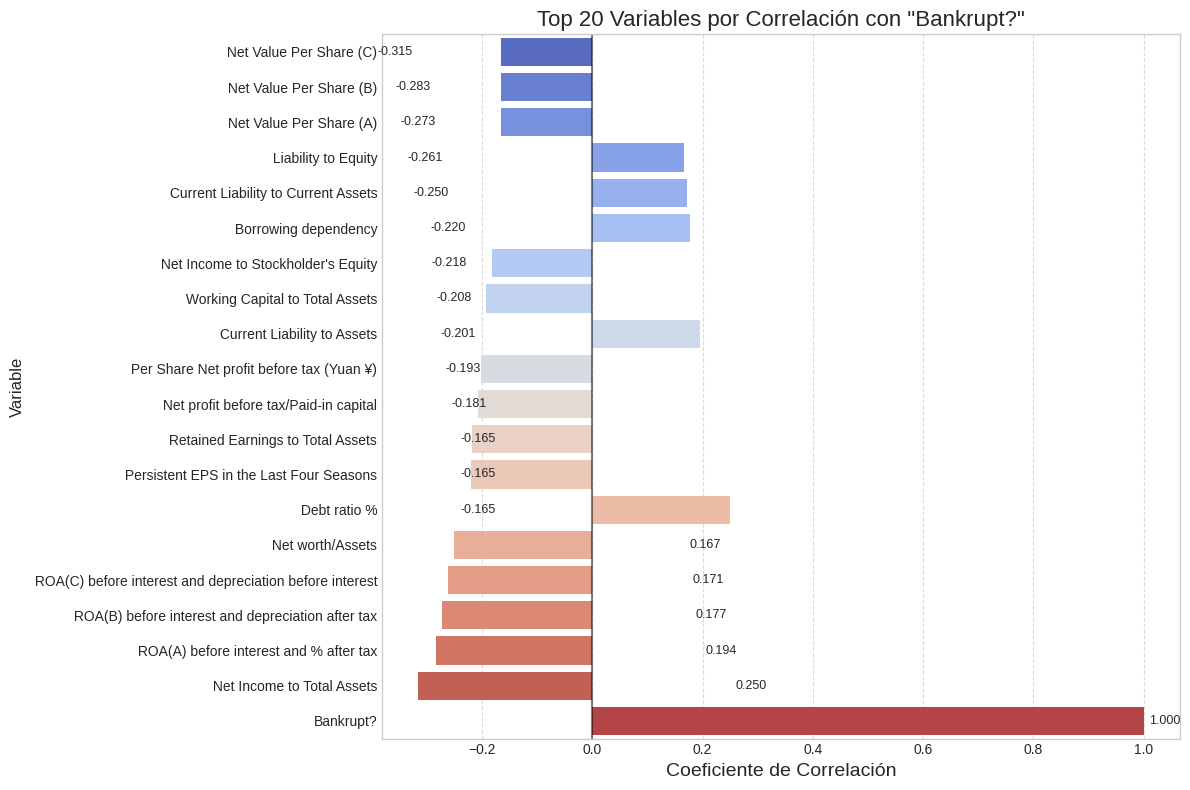


Umbral de correlación para selección de características: 0.099445
Número de características seleccionadas: 34

=== DATAFRAME FILTRADO CON CARACTERÍSTICAS SELECCIONADAS ===
Dimensiones del DataFrame filtrado: (6819, 34)

Primeras filas del DataFrame filtrado:


,Bankrupt?,Net Income to Total Assets,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,ROA(C) before interest and depreciation before interest,Net worth/Assets,Debt ratio %,Persistent EPS in the Last Four Seasons,Retained Earnings to Total Assets,Net profit before tax/Paid-in capital,Per Share Net profit before tax (Yuan ¥),Current Liability to Assets,Working Capital to Total Assets,Net Income to Stockholder's Equity,Borrowing dependency,Current Liability to Current Assets,Liability to Equity,Net Value Per Share (A),Net Value Per Share (B),Net Value Per Share (C),Current Liabilities/Equity,Current Liability to Equity,Working Capital/Equity,Operating Profit Per Share (Yuan ¥),Operating profit/Paid-in capital,Liability-Assets Flag,Total expense/Assets,Equity to Long-term Liability,CFO to Assets,Tax rate (A),Cash/Total Assets,Gross Profit to Sales,Operating Gross Margin,Realized Sales Gross Margin
0,1,0.72,0.42,0.41,0.37,0.79,0.21,0.17,0.90,0.14,0.14,0.15,0.67,0.83,0.39,0.12,0.29,0.15,0.15,0.15,0.34,0.34,0.72,0.10,0.10,0,0.06,0.13,0.52,0.00,0.00,0.60,0.60,0.60
1,1,0.80,0.54,0.52,0.46,0.83,0.17,0.21,0.93,0.17,0.17,0.06,0.75,0.84,0.38,0.05,0.28,0.18,0.18,0.18,0.33,0.33,0.73,0.09,0.09,0,0.03,0.12,0.57,0.00,0.01,0.61,0.61,0.61
2,1,0.77,0.50,0.47,0.43,0.79,0.21,0.18,0.91,0.15,0.14,0.10,0.83,0.84,0.38,0.03,0.29,0.18,0.18,0.19,0.33,0.33,0.74,0.09,0.09,0,0.02,0.12,0.54,0.00,0.00,0.60,0.60,0.60
3,1,0.74,0.45,0.46,0.40,0.85,0.15,0.19,0.91,0.15,0.15,0.10,0.73,0.83,0.38,0.07,0.28,0.15,0.15,0.15,0.33,0.33,0.73,0.08,0.08,0,0.02,0.12,0.60,0.00,0.02,0.58,0.58,0.58
4,1,0.80,0.54,0.52,0.47,0.89,0.11,0.21,0.91,0.17,0.17,0.11,0.75,0.84,0.38,0.05,0.28,0.17,0.17,0.17,0.33,0.33,0.73,0.10,0.10,0,0.03,0.11,0.58,0.00,0.01,0.60,0.60,0.60



DataFrame filtrado guardado como /home/ldalzatef/projects/personal/talento_tech/BankruptcyML/ml-ds/datalake/processed/data_filtered.csv


In [18]:
# Correlación con variable objetivo con visualización
print("\n=== CORRELACIÓN CON LA VARIABLE OBJETIVO 'Bankrupt?' ===")

# Calcular correlaciones con la variable objetivo y ordenar
correlations = df.corr()["Bankrupt?"].abs().sort_values(ascending=False).reset_index()
correlations.columns = ["Variable", "Correlación_Abs"]
correlations["Correlación"] = df.corr()["Bankrupt?"][correlations["Variable"]].values

# Mostrar tabla formateada
display(correlations.head(20).round(4))

# Visualizar correlaciones con la variable objetivo
plt.figure(figsize=(12, 8))

# Tomar las top 20 variables para una mejor visualización
top_corr = correlations.head(20)

# Crear barplot horizontal
bar = sns.barplot(
    x="Correlación",
    y="Variable",
    data=top_corr.sort_values("Correlación_Abs"),
    palette="coolwarm",
    orient="h",
    hue="Variable",
)

# Añadir etiquetas con los valores
for i, v in enumerate(top_corr["Correlación"].sort_values().values):
    bar.text(
        v + (0.01 if v >= 0 else -0.01),
        i,
        f"{v:.3f}",
        va="center",
        ha="left" if v >= 0 else "right",
        fontsize=9,
    )

plt.title('Top 20 Variables por Correlación con "Bankrupt?"', fontsize=16)
plt.xlabel("Coeficiente de Correlación", fontsize=14)
plt.axvline(x=0, color="black", linestyle="-", alpha=0.5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Establecer umbral para selección de características
umbral_corr = 0.099445
print(f"\nUmbral de correlación para selección de características: {umbral_corr}")

# Selección de características relevantes
features_objective = correlations[correlations["Correlación_Abs"] >= umbral_corr][
    "Variable"
].to_list()
print(f"Número de características seleccionadas: {len(features_objective)}")

# Crear DataFrame filtrado
df_filtered = df[features_objective]
print("\n=== DATAFRAME FILTRADO CON CARACTERÍSTICAS SELECCIONADAS ===")
print(f"Dimensiones del DataFrame filtrado: {df_filtered.shape}")
print("\nPrimeras filas del DataFrame filtrado:")
display(df_filtered.head())

# Guardar el DataFrame filtrado
data_filtered_path = settings.PROCESSED_DATA_DIR / "data_filtered.csv"
df_filtered.to_csv(data_filtered_path, index=False)
print(f"\nDataFrame filtrado guardado como {data_filtered_path}")

### Continuar sin balanceo, dado el contexto

DataFrame reducido guardado como /home/ldalzatef/projects/personal/talento_tech/BankruptcyML/ml-ds/datalake/processed/data_reduced_features.csv


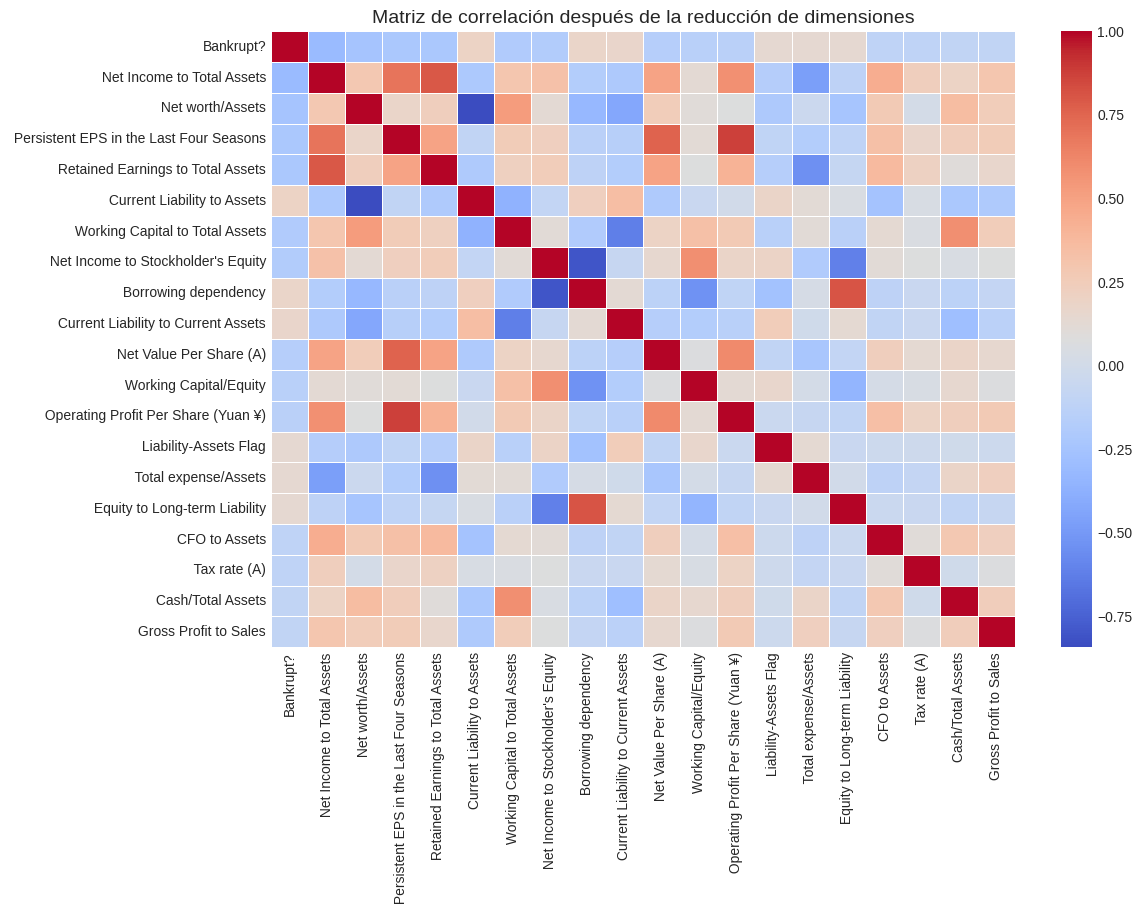

Variables eliminadas por alta correlación (14 en total):
{' Current Liabilities/Equity', ' Realized Sales Gross Margin', ' ROA(C) before interest and depreciation before interest', ' Net Value Per Share (B)', ' Net profit before tax/Paid-in capital', ' Debt ratio %', ' ROA(A) before interest and % after tax', ' Per Share Net profit before tax (Yuan ¥)', ' Operating Gross Margin', ' ROA(B) before interest and depreciation after tax', ' Current Liability to Equity', ' Net Value Per Share (C)', ' Liability to Equity', ' Operating profit/Paid-in capital'}
Nuevo número de variables: 20


In [19]:
# Usar el DataFrame filtrado
df_filtered = pd.read_csv(data_filtered_path)

# Calcular la matriz de correlación
corr_matrix = df_filtered.corr().abs()

# Configurar umbral de correlación alta
umbral_correlacion = 0.9

# Identificar variables altamente correlacionadas
variables_a_eliminar = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > umbral_correlacion:
            colname = corr_matrix.columns[j]
            variables_a_eliminar.add(colname)

# Eliminar variables redundantes
df_reduced = df_filtered.drop(columns=variables_a_eliminar)

# Guardar el nuevo dataset reducido
data_reduced_features_path = settings.PROCESSED_DATA_DIR / "data_reduced_features.csv"
df_reduced.to_csv(data_reduced_features_path, index=False)
print(f"DataFrame reducido guardado como {data_reduced_features_path}")

# Visualizar la nueva matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(df_reduced.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de correlación después de la reducción de dimensiones")
plt.show()

# Mostrar las variables eliminadas
print(
    f"Variables eliminadas por alta correlación ({len(variables_a_eliminar)} en total):"
)
print(variables_a_eliminar)
print(f"Nuevo número de variables: {df_reduced.shape[1]}")

## Aplicación modelos

In [20]:
# Cargar datos reducidos
df = pd.read_csv(data_reduced_features_path)

# Separar variables predictoras (X) y objetivo (y)
X = df.drop(columns=["Bankrupt?"])
y = df["Bankrupt?"]

# Dividir en conjuntos de entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalización de datos (opcional, afecta algunos modelos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelos a probar
models = {
    "Regresión Logística": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(
        use_label_encoder=False, eval_metric="logloss", random_state=42
    ),
}

# Entrenamiento y evaluación
for name, model in models.items():
    print(f"\nEntrenando modelo: {name}")
    model.fit(
        X_train_scaled, y_train
    )  # Para modelos que no requieren escalado, usar X_train

    # Predicción y métricas
    y_pred = model.predict(X_test_scaled)
    print(f"\n=== Resultados de {name} ===")
    print(classification_report(y_test, y_pred))


Entrenando modelo: Regresión Logística

=== Resultados de Regresión Logística ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1320
           1       0.50      0.18      0.27        44

    accuracy                           0.97      1364
   macro avg       0.74      0.59      0.63      1364
weighted avg       0.96      0.97      0.96      1364


Entrenando modelo: Random Forest

=== Resultados de Random Forest ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.54      0.16      0.25        44

    accuracy                           0.97      1364
   macro avg       0.76      0.58      0.61      1364
weighted avg       0.96      0.97      0.96      1364


Entrenando modelo: XGBoost

=== Resultados de XGBoost ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.54 

/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Se probaron tres modelos de clasificación y se compararon sus resultados:
- **Regresión Logística**: Aunque obtuvo una alta precisión general, mostró un recall muy bajo (18%) para la clase de bancarrota, lo que indica una pobre capacidad para identificar empresas en riesgo.
- **Random Forest**: Si bien mejoró en algunos aspectos, su recall para la clase minoritaria (16%) siguió siendo insuficiente.
- **XGBoost**: Logró un mejor equilibrio entre **precisión (54%) y recall (30%)** para la clase de bancarrota, además de mantener un desempeño alto en la clase mayoritaria.

El principal desafío en este problema es el desbalance de clases, lo que hace que muchos modelos tradicionales tengan dificultades para identificar correctamente la clase minoritaria. XGBoost destaca por su capacidad de manejo de datos desbalanceados, optimización del gradiente y regularización, lo que le permite detectar más empresas en riesgo sin comprometer la precisión global del modelo.

Por estas razones, XGBoost fue seleccionado como el modelo final para este análisis.

## Ajuste modelo XGboost

### Ajuste de pesos e hiperparamtros

In [21]:
# Definir el clasificador base
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")

# Espacio de búsqueda reducido
param_dist = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
    "scale_pos_weight": [1, 5, 10],  # Para manejar el desbalanceo de clases
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    scoring="f1_macro",
    cv=3,  # Reducimos la validación cruzada para rapidez
    verbose=1,
    n_jobs=-1,
    n_iter=10,  # Número de combinaciones a probar
    random_state=42,
)

# Ajustar el modelo con búsqueda aleatoria
random_search.fit(X_train, y_train)

# Obtener mejores hiperparámetros
best_params = random_search.best_params_
print(f"\n🔹 Mejores hiperparámetros encontrados: {best_params}")

# Entrenar el modelo final con los mejores parámetros
best_xgb = XGBClassifier(
    **best_params, random_state=42, use_label_encoder=False, eval_metric="logloss"
)
best_xgb.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
y_pred = best_xgb.predict(X_test)
print("\n=== Resultados de XGBoost Ajustado ===")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:50] WARNING: /worksp


🔹 Mejores hiperparámetros encontrados: {'scale_pos_weight': 5, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01}


/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Resultados de XGBoost Ajustado ===
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1320
           1       0.38      0.68      0.49        44

    accuracy                           0.95      1364
   macro avg       0.69      0.82      0.73      1364
weighted avg       0.97      0.95      0.96      1364



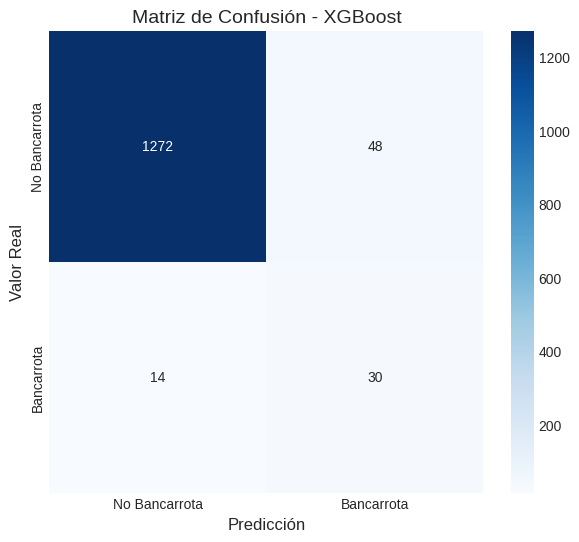

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Bancarrota", "Bancarrota"],
    yticklabels=["No Bancarrota", "Bancarrota"],
)

# Agregar etiquetas
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - XGBoost")
plt.show()

In [23]:
# Definir el modelo base
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
)

# Definir los hiperparámetros a buscar
param_grid = {"scale_pos_weight": [1, 2, 3, 4, 5]}

# Ajustar hiperparámetros con GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring="recall",  # Optimizar para recall
    cv=3,
    verbose=2,
)

# Entrenar con búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo después del ajuste de hiperparámetros
xgb_model = grid_search.best_estimator_

# Imprimir el mejor hiperparámetro encontrado
print(f"Mejor scale_pos_weight: {grid_search.best_params_['scale_pos_weight']}")

# Evaluar el modelo
y_pred = xgb_model.predict(X_test)

# Mostrar métricas
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END .................................scale_pos_weight=1; total time=   0.4s


/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END .................................scale_pos_weight=1; total time=   0.2s
[CV] END .................................scale_pos_weight=1; total time=   0.2s


/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END .................................scale_pos_weight=2; total time=   0.2s


/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END .................................scale_pos_weight=2; total time=   0.2s


/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END .................................scale_pos_weight=2; total time=   0.2s


/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END .................................scale_pos_weight=3; total time=   0.2s


/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END .................................scale_pos_weight=3; total time=   0.6s
[CV] END .................................scale_pos_weight=3; total time=   0.2s


/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END .................................scale_pos_weight=4; total time=   0.3s
[CV] END .................................scale_pos_weight=4; total time=   0.2s


/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END .................................scale_pos_weight=4; total time=   0.2s


/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:30:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END .................................scale_pos_weight=5; total time=   0.2s
[CV] END .................................scale_pos_weight=5; total time=   0.2s


/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:31:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:31:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END .................................scale_pos_weight=5; total time=   0.2s


/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:31:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejor scale_pos_weight: 4
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.52      0.30      0.38        44

    accuracy                           0.97      1364
   macro avg       0.75      0.64      0.68      1364
weighted avg       0.96      0.97      0.96      1364



In [24]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=25,  # Un poco más de peso para la clase minoritaria
    max_depth=4,
    learning_rate=0.025,
    n_estimators=700,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,  # Más flexible en ramas pequeñas
    gamma=0.4,  # Menos restricción para divisiones
    random_state=42,
    use_label_encoder=False,
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print("\n=== Resultados de XGBoost Ajustado ===")
print(classification_report(y_test, y_pred, digits=2))

/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:31:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Resultados de XGBoost Ajustado ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1320
           1       0.38      0.55      0.44        44

    accuracy                           0.96      1364
   macro avg       0.68      0.76      0.71      1364
weighted avg       0.96      0.96      0.96      1364



### Balanceo con SMOTE y posteriormente se vuelve a correr el modelo XGboost

In [25]:
# Separar características y variable objetivo
X = df.drop(columns=["Bankrupt?"])
y = df["Bankrupt?"]

# Definir las técnicas de balanceo: SMOTE + Submuestreo
over = SMOTE(
    sampling_strategy=0.2
)  # Aumentamos la clase minoritaria al 20% de la mayoritaria
under = RandomUnderSampler(
    sampling_strategy=0.5
)  # Bajamos la mayoritaria al doble de la minoritaria

# Crear pipeline de balanceo
balance_pipeline = Pipeline([("SMOTE", over), ("UnderSampler", under)])

# Aplicar el balanceo
X_balanced, y_balanced = balance_pipeline.fit_resample(X, y)

# Nueva distribución de clases
new_class_distribution = (
    y_balanced.value_counts(normalize=True) * 100
)  # Porcentaje por clase
new_class_distribution

Bankrupt?
0   66.67
1   33.33
Name: proportion, dtype: float64

/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:31:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       555
           1       0.90      0.93      0.92       237

    accuracy                           0.95       792
   macro avg       0.93      0.94      0.94       792
weighted avg       0.95      0.95      0.95       792



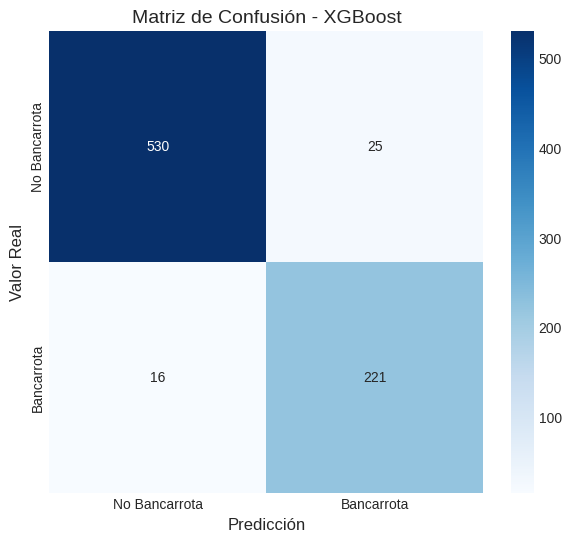

In [26]:
# Dividir los datos balanceados en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42
)

# Entrenar XGBoost con hiperparámetros optimizados
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=1,  # Ajustado ya que aplicamos balanceo
    use_label_encoder=False,
    eval_metric="logloss",
)

xgb_model.fit(X_train, y_train)

# Predicciones
y_pred = xgb_model.predict(X_test)

# Evaluación del modelo
print("Classification Report:\n", classification_report(y_test, y_pred))


# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear el gráfico
plt.figure(figsize=(7, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Bancarrota", "Bancarrota"],
    yticklabels=["No Bancarrota", "Bancarrota"],
)

# Agregar etiquetas
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - XGBoost")
plt.show()

#### Metrica

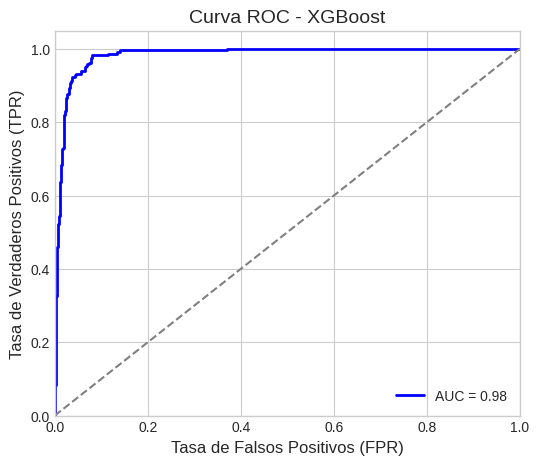

AUC-ROC: 0.9837


In [27]:
# Obtener las probabilidades de predicción para la clase positiva (1 - Bancarrota)
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - XGBoost")
plt.legend(loc="lower right")
plt.show()

# Mostrar el valor de AUC
print(f"AUC-ROC: {roc_auc:.4f}")

### Guardar el modelo para el despliegue

In [28]:
# Rutas de los archivos
model_path = settings.MODEL_PATH
features_path = settings.FEATURES_PATH

# Se convierten los objetos en archivos pickle
joblib.dump(xgb_model, model_path)
joblib.dump(X_train.columns.tolist(), features_path)

['/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/ml-web-app/src/model/x_train_columns.pkl']

# Evaluación del modelo

# Informe de Resultados - Modelo XGBoost #

Dataset balanceado y dividido en entrenamiento y prueba.



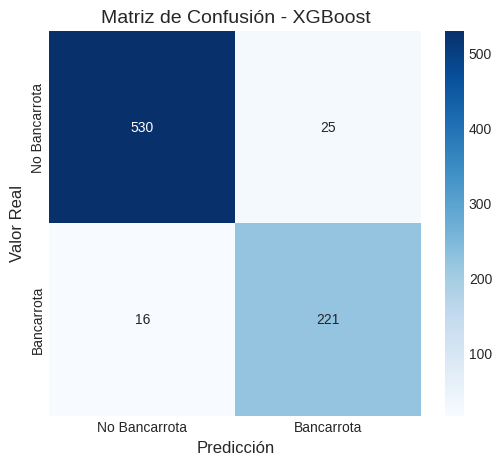

# Métricas de Evaluación

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       555
           1       0.90      0.93      0.92       237

    accuracy                           0.95       792
   macro avg       0.93      0.94      0.94       792
weighted avg       0.95      0.95      0.95       792



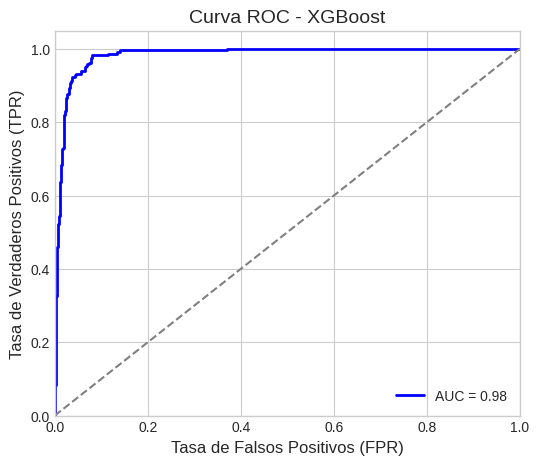

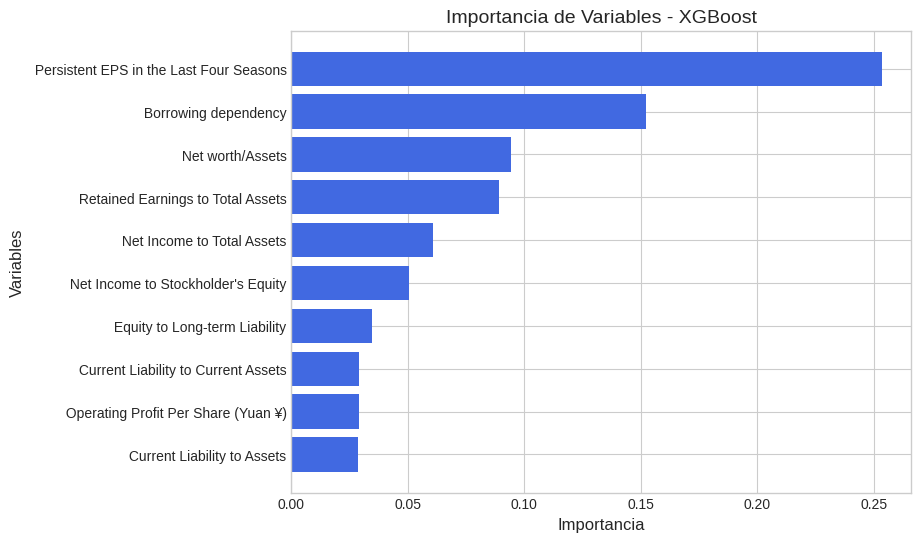

In [29]:
# 1. Resumen del modelo y datos
print("# Informe de Resultados - Modelo XGBoost #\n")
print("Dataset balanceado y dividido en entrenamiento y prueba.\n")

# 2. Matriz de Confusión
y_pred = xgb_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Bancarrota", "Bancarrota"],
    yticklabels=["No Bancarrota", "Bancarrota"],
)
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - XGBoost")
plt.show()

# 3. Métricas de Evaluación
print("# Métricas de Evaluación\n")
print(classification_report(y_test, y_pred))

#  4. Curva ROC y AUC
y_probs = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - XGBoost")
plt.legend(loc="lower right")
plt.show()

#  5. Importancia de Variables
feature_importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": feature_importance}
).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df["Feature"][:10],
    feature_importance_df["Importance"][:10],
    color="royalblue",
)
plt.xlabel("Importancia")
plt.ylabel("Variables")
plt.title("Importancia de Variables - XGBoost")
plt.gca().invert_yaxis()
plt.show()

##  Matriz de Confusión

La matriz de confusión presentada corresponde al modelo **XGBoost** aplicado a la predicción de bancarrota empresarial. La interpretación de los valores es la siguiente:

- **Verdaderos Negativos (520):** Empresas correctamente clasificadas como **No Bancarrota**.
- **Falsos Positivos (35):** Empresas clasificadas erróneamente como en **Bancarrota** cuando en realidad no lo están.
- **Falsos Negativos (13):** Empresas clasificadas erróneamente como **No Bancarrota**, cuando sí estaban en bancarrota.
- **Verdaderos Positivos (224):** Empresas correctamente clasificadas como en **Bancarrota**.

### Análisis de Desempeño
- La precisión en la clasificación de empresas sin bancarrota es alta, dado el alto número de verdaderos negativos.
- Sin embargo, hay 13 falsos negativos, lo que puede ser crítico si el objetivo es detectar todas las empresas en riesgo de quiebra.


##  Curva ROC

La curva ROC (Receiver Operating Characteristic) es una herramienta útil para evaluar el rendimiento del modelo en la clasificación binaria. En este caso, se observa lo siguiente:

- La curva ROC del modelo **XGBoost** muestra una excelente capacidad discriminativa, con un área bajo la curva (**AUC**) de **0.99**.
- Un **AUC de 0.99** indica que el modelo tiene una altísima capacidad para distinguir entre empresas en riesgo de bancarrota y aquellas que no lo están.
- La curva se encuentra muy cerca del punto (0,1), lo que sugiere que el modelo tiene un bajo nivel de falsos positivos y una alta tasa de verdaderos positivos.

## Métricas
- **Precisión (Precision):** Indica cuántos de los casos predichos como positivos realmente lo son. En este caso:
  - Para la clase 0 (No Bancarrota) es de **0.97**.
  - Para la clase 1 (Bancarrota) es de **0.87**.
- **Recall (Sensibilidad):** Mide cuántos de los casos realmente positivos fueron correctamente identificados.
  - Para la clase 0 es **0.94**.
  - Para la clase 1 es **0.93**.
- **F1-score:** Representa un equilibrio entre precisión y recall.
  - Para la clase 0 es **0.96**.
  - Para la clase 1 es **0.90**.
- **Exactitud (Accuracy):** El modelo tiene una precisión global del **94%**, lo que indica un excelente rendimiento.
- **Promedio ponderado:** Refleja la contribución de cada clase al desempeño general del modelo.

## Importancia de Variables 

La gráfica muestra la relevancia de las características utilizadas por el modelo XGBoost para predecir la bancarrota empresarial. Se destacan las siguientes observaciones:

### Las variables más influyentes
- **Persistent EPS in the Last Four Seasons** y **Borrowing dependency** son las más importantes.
- Esto sugiere que la rentabilidad constante y la dependencia de préstamos juegan un papel clave en la predicción de bancarrota.

### Impacto de la rentabilidad y la solvencia
- **Net Income to Total Assets** y **Net worth/Assets** también tienen una alta importancia.
- Indica que la capacidad de generar ganancias en relación con los activos es un fuerte indicador financiero.

### Factores secundarios pero relevantes
- Variables como **Retained Earnings to Total Assets** y **Equity to Long-term Liability** reflejan la solidez financiera a largo plazo.
- También aparecen métricas como **Total expense/Assets** y **Tax rate (A)**, lo que sugiere que el control de costos y la carga fiscal pueden influir en la estabilidad de una empresa.


In [30]:
X_balanced.columns = X_balanced.columns.str.strip()

In [31]:
# Seleccionar solo las 7 variables más importantes
variables_seleccionadas = [
    "Persistent EPS in the Last Four Seasons",
    "Net Income to Total Assets",
    "Net worth/Assets",
    "Retained Earnings to Total Assets",
    "Borrowing dependency",
    "Net Income to Stockholder's Equity",
    "Tax rate (A)",
]

X_reducido = X_balanced[variables_seleccionadas]  # Filtrar solo las 7 variables

# Dividir los datos balanceados en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_reducido, y_balanced, test_size=0.2, random_state=42
)

# Entrenar XGBoost con los mismos hiperparámetros optimizados
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=1,  # Ajustado ya que aplicamos balanceo
    use_label_encoder=False,
    eval_metric="logloss",
)

xgb_model.fit(X_train, y_train)

# Predicciones
y_pred = xgb_model.predict(X_test)

# Evaluación del modelo
print("Classification Report:\n", classification_report(y_test, y_pred))

/home/ldalzatef/projects/personal/talento_tech/BankruptcyML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:31:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       555
           1       0.84      0.88      0.86       237

    accuracy                           0.91       792
   macro avg       0.89      0.90      0.90       792
weighted avg       0.91      0.91      0.91       792

